In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler
import time 

In [2]:

import plotly.graph_objects as go
import plotly.io as pio

try:
    import google.colab
    pio.renderers.default = 'colab'
    print("Entorno detectado: Google Colab. Renderizador configurado como 'colab'.")
except ImportError:
    pio.renderers.default = 'notebook'
    print("Entorno detectado: Local (jupyter). Renderizador configurado como 'notebook'.")


Entorno detectado: Local (jupyter). Renderizador configurado como 'notebook'.


In [3]:
df = pd.read_csv("../data/match_data_compact.csv")

scaler = RobustScaler().set_output(transform="pandas")
X = df.drop(columns=["blueTeamWin"])
X = scaler.fit_transform(X)
y = df["blueTeamWin"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [4]:
start = time.time()

dt = SVC(random_state = 42)

param_grid = [
    {
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10]
    },
    {
        'kernel': ['poly'],
        'C': [ 0.1, 1],
        'degree': [2, 5] 
    }
]

grid_search = GridSearchCV(estimator = dt,
                    param_grid = param_grid,
                    n_jobs=-1,
                    cv = 4,
                    scoring='accuracy')


grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)
print(time.time()-start)

Mejores parámetros: {'C': 0.1, 'kernel': 'linear'}
Mejor puntuación de validación cruzada: 0.7642121602212223
53.165287256240845


Podemos ver que tenemos unos valores de C:0.1 y kernel:lineal. Estos valores nos indican que nuestros datos siguen una relación siemple ( por lo que no vale la pena coger un modelo mas complejo, solo sobreajustará los datos). Como es un modelo lineal, en vez de usar SVC podemos usar LinearSVC que utiliza un algoritmo mucho mejor optimizado para el caso lineal.

In [12]:
model = grid_search.best_estimator_
y_pred = model.predict(X_val)

print("Matriz de confusión:")
print(confusion_matrix(y_val, y_pred))
print("\nInforme de clasificación:")
print(classification_report(y_val, y_pred))

Matriz de confusión:
[[1824  611]
 [ 614 1795]]

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2435
           1       0.75      0.75      0.75      2409

    accuracy                           0.75      4844
   macro avg       0.75      0.75      0.75      4844
weighted avg       0.75      0.75      0.75      4844



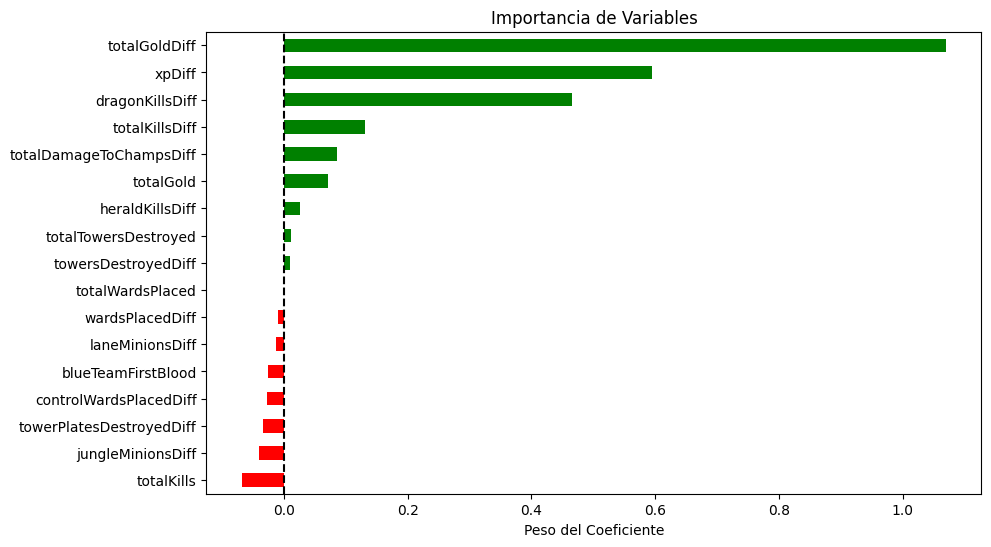

In [6]:
coeficientes = (best_dt.coef_.flatten())
feat_imp = pd.Series(coeficientes, index=X_train.columns).sort_values()
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh', color=np.where(feat_imp > 0, 'green', 'red'))
plt.title("Importancia de Variables")
plt.xlabel("Peso del Coeficiente")
plt.axvline(x=0, color='black', linestyle='--') 
plt.show()

In [7]:
df_ng = pd.read_csv("../data/match_data_no_gold.csv")

scaler = RobustScaler().set_output(transform="pandas")
X_ng = df_ng.drop(columns=["blueTeamWin"])
X_ng = scaler.fit_transform(X_ng)
y = df_ng["blueTeamWin"]
X_train, X_val, y_train, y_val = train_test_split(X_ng, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
start = time.time()

dt = SVC(random_state = 42)

param_grid = [
    {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10]
    },
    {
        'kernel': ['poly'],
        'C': [ 0.1, 1,10],
        'degree': [2, 5] 
    }
]

grid_search = GridSearchCV(estimator = dt,
                    param_grid = param_grid,
                    n_jobs=-1,
                    cv = 4,
                    scoring='accuracy')


grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)
print(time.time()-start)

Mejores parámetros: {'C': 1, 'kernel': 'linear'}
Mejor puntuación de validación cruzada: 0.7611842458266187
191.5747480392456


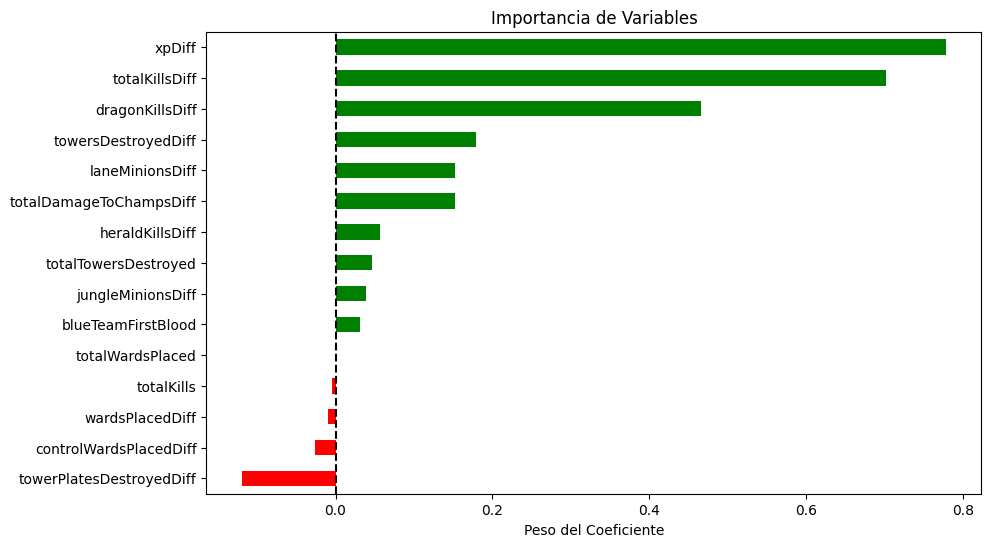

In [8]:
coeficientes = (best_dt.coef_.flatten())
b = best_dt.intercept_[0]
feat_imp = pd.Series(coeficientes, index=X_train.columns).sort_values()
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh', color=np.where(feat_imp > 0, 'green', 'red'))
plt.title("Importancia de Variables")
plt.xlabel("Peso del Coeficiente")
plt.axvline(x=0, color='black', linestyle='--') 
plt.show()

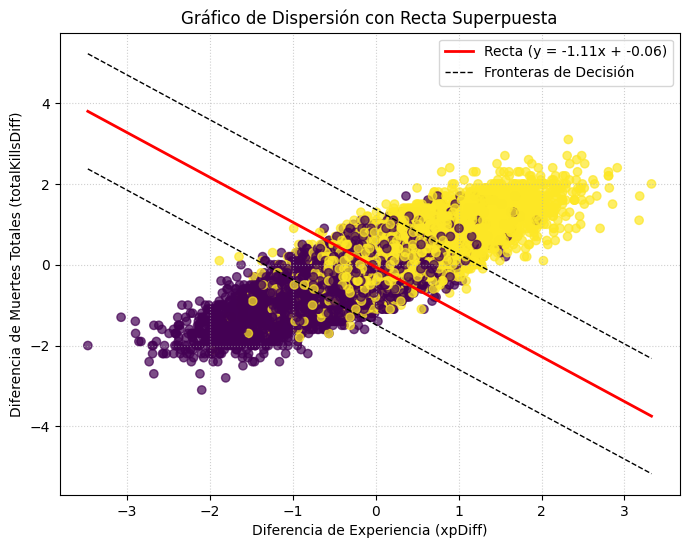

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


np.random.seed(42)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X["xpDiff"], X["totalKillsDiff"], c=y, cmap='viridis', alpha=0.7)


intercept = b
w0 = coeficientes[9] #coeficiente asociado a xpdiff
w1 = coeficientes[2] #coeficiente asociado a totalKillsDiff
M = - w0/w1
B = -intercept / w1
norm_w = np.linalg.norm(coeficientes[0])
distancia_a_frontera = 1 / norm_w
anchura_del_margen = 2 * distancia_a_frontera
x_min = X_ng["xpDiff"].min()
x_max = X_ng["xpDiff"].max()


x_line = np.linspace(x_min, x_max, 100)

y_line = M * x_line + B

y_up = M * x_line + B + (1 / w1)


y_down = M * x_line + B - (1 / w1)

margin_offset = distancia_a_frontera / w1

plt.plot(x_line, y_line, color='red', linewidth=2, label=f'Recta (y = {M:.2f}x + {B:.2f})')
plt.plot(x_line, y_up, color='k', linestyle='--', linewidth=1, label='Fronteras de Decisión')
plt.plot(x_line, y_down, color='k', linestyle='--', linewidth=1)


plt.xlabel("Diferencia de Experiencia (xpDiff)")
plt.ylabel("Diferencia de Muertes Totales (totalKillsDiff)")
plt.title("Gráfico de Dispersión con Recta Superpuesta")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

### Proyección del Hiperplano SVM a 2D

Para pasar el hiperplano de SVM de $N$-dimensiones a una recta visualizable en 2D, partimos de la ecuación general del hiperplano:

$$w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b = 0$$

Para simplificar a 2D, tomamos los **promedios** (o valores centrales) de las variables que no vamos a graficar $\{x_3, x_4, \dots, x_n\}$. Definimos un nuevo sesgo efectivo $B'$ que agrupa estos términos constantes:

$$B' = b + \sum_{i=3}^{n} w_i \cdot \bar{x}_i$$

Dado que hemos escalado los datos con **RobustScaler** , asumimos que el valor central de estas variables es **0**. Por lo tanto, el término de la sumatoria se anula y obtenemos que $b \approx B'$ (No es exactamente 0 porque resta la mediana y no la media). La ecuación reducida para el plano 2D queda:

$$w_1 x_1 + w_2 x_2 + b = 0$$

Para obtener la ecuación de la recta (forma $y = mx + c$), despejamos la segunda variable ($x_2$):

$$x_2 = -\frac{w_1}{w_2} x_1 - \frac{b}{w_2}$$

Finalmente, para calcular las **rectas de las fronteras (márgenes)**, imponemos la condición de margen $ = 1$ y $ = -1$. Esto equivale a sumar y restar una unidad al término independiente de la ecuación original, lo que se traduce en un desplazamiento vertical en la recta final:

$$x_2 = -\frac{w_1}{w_2} x_1 - \frac{b \pm 1}{w_2}$$

Es decir, sumamos y restamos el término $\frac{1}{w_2}$ a la recta de decisión.

In [32]:

variables = pd.Series(["xpDiff","totalKillsDiff","dragonKillsDiff"])
w = coeficientes[[9,2,3]]
M0 = -w[0] / w[2]
M1 = -w[1] / w[2]
B = -b/w[2]
fig = go.Figure()
dist = 1 / w[2]

fig.add_trace(go.Scatter3d(
    x=X_ng[variables[0]],
    y=X_ng[variables[1]],
    z=X_ng[variables[2]],
    opacity=0.8,
    mode='markers',
    marker=dict(size=5, color=y, colorscale='Viridis'),
    name='Data'
))

x_min, x_max = -1, 1
y_min, y_max = -1, 1
x_range = np.linspace(x_min, x_max, 50)
y_range = np.linspace(y_min, y_max, 50)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = M0 * X_grid + M1 * Y_grid + B

z2 = Z_grid + dist
z3 = Z_grid - dist


fig.add_trace(
    go.Surface(
        x=X_grid,
        y=Y_grid,
        z=Z_grid,
        name='Hiperplano Separador',
        opacity=0.7,          
        showscale=False,       
        colorscale=[[0, 'red'], [1, 'red']] 
    )
)

fig.update_layout(
    scene=dict(
        xaxis_title=variables[0],
        yaxis_title=variables[1],
        zaxis_title=variables[2],
    ),
    title='Scatter Plot',
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()



In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                       for i in range(len(X.columns))]

vif_data

,Variable,VIF
0,controlWardsPlacedDiff,1.048429
1,wardsPlacedDiff,1.012280
2,totalKillsDiff,10.566067
3,dragonKillsDiff,1.218669
4,heraldKillsDiff,1.086991
5,towersDestroyedDiff,2.475315
6,towerPlatesDestroyedDiff,2.118567
7,laneMinionsDiff,2.963087
8,jungleMinionsDiff,1.658089
9,totalGoldDiff,19.782145


In [19]:
columnas = X.columns
maxim = fila_max = vif_data[vif_data['VIF'] == vif_data['VIF'].max()]
while maxim["VIF"].iloc[0] > 5:
    print(maxim["Variable"])
    columnas = columnas[columnas!=maxim["Variable"].iloc[0]]
    vif_data = pd.DataFrame()
    vif_data["Variable"] = columnas
    vif_data["VIF"] = [variance_inflation_factor(X[columnas].values, i) 
                       for i in range(len(columnas))]
    maxim = fila_max = vif_data[vif_data['VIF'] == vif_data['VIF'].max()]

    

9    totalGoldDiff
Name: Variable, dtype: object
9    xpDiff
Name: Variable, dtype: object
13    totalGold
Name: Variable, dtype: object


In [20]:
vif_data

,Variable,VIF
0,controlWardsPlacedDiff,1.044711
1,wardsPlacedDiff,1.011839
2,totalKillsDiff,2.792958
3,dragonKillsDiff,1.215467
4,heraldKillsDiff,1.070042
5,towersDestroyedDiff,2.046460
6,towerPlatesDestroyedDiff,1.944286
7,laneMinionsDiff,1.736389
8,jungleMinionsDiff,1.194381
9,totalDamageToChampsDiff,2.696372


In [21]:
X_proc = df[vif_data["Variable"]]
X_proc = scaler.fit_transform(X_proc)


X_train, X_val, y_train, y_val = train_test_split(X_proc, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [22]:


start = time.time()

dt = SVC(random_state = 42)
dt2 = LinearSVC(random_state=42)
par = {'C':[0.1,1,10,1000,500,10000]}
param_grid = [
    {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10,100]
    },
    {
        'kernel': ['poly'],
        'C': [ 1],
        'degree': [2 ] 
    }
]

grid_search = GridSearchCV(estimator = dt,
                    param_grid = param_grid,
                    n_jobs=-1,
                    cv = 5,
                    scoring='accuracy')


grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)
print(time.time()-start)


Mejores parámetros: {'C': 10, 'kernel': 'linear'}
Mejor puntuación de validación cruzada: 0.7602202339986235
212.6882016658783


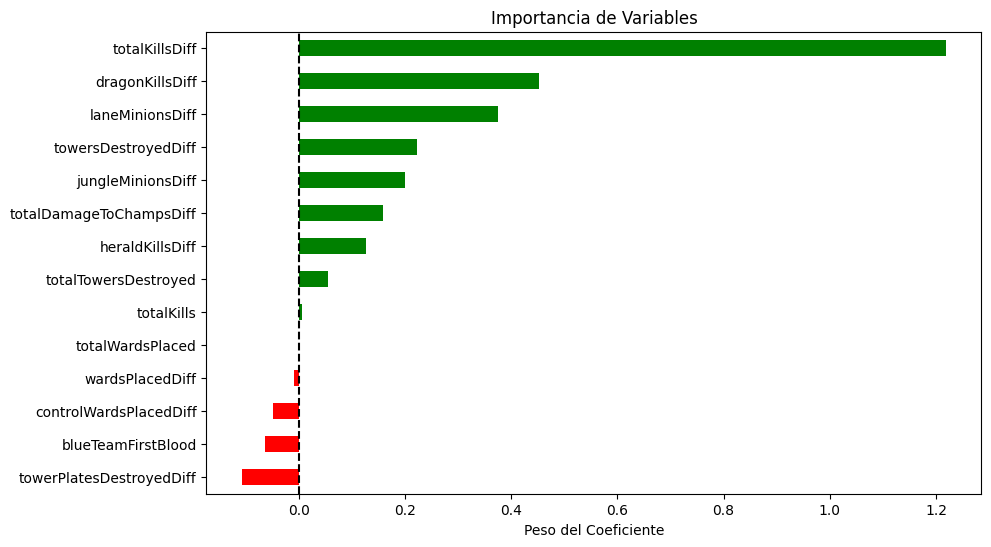

In [23]:
coeficientes = (best_dt.coef_.flatten())
b = best_dt.intercept_[0]
feat_imp = pd.Series(coeficientes, index=X_train.columns).sort_values()
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh', color=np.where(feat_imp > 0, 'green', 'red'))
plt.title("Importancia de Variables")
plt.xlabel("Peso del Coeficiente")
plt.axvline(x=0, color='black', linestyle='--') 
plt.show()

In [24]:
coeficientes

array([-4.77652410e-02, -9.35404139e-03,  1.21936471e+00,  4.53149166e-01,
        1.26858101e-01,  2.22965872e-01, -1.07119016e-01,  3.76340354e-01,
        1.99740808e-01,  1.59342976e-01,  6.68013996e-03,  5.56426147e-02,
        4.61440942e-04, -6.29542328e-02])

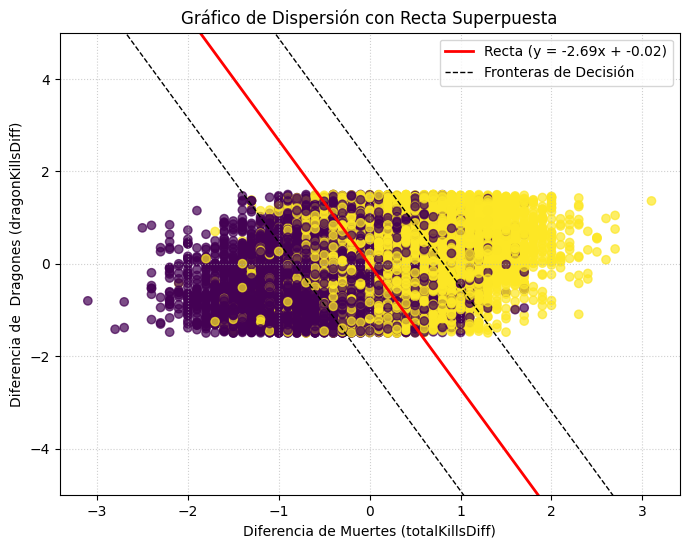

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


np.random.seed(42)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_proc["totalKillsDiff"], X_proc["dragonKillsDiff"] + (np.random.rand(X_proc.shape[0])-0.5), c=y, cmap='viridis', alpha=0.7)


w0 = coeficientes[2] 
w1 = coeficientes[3]
M = - w0/w1
B = -b / w1
norm_w = np.linalg.norm(coeficientes)
distancia_a_frontera = 1 / norm_w
anchura_del_margen = 2 * distancia_a_frontera
x_min = X_proc["totalKillsDiff"].min()
x_max = X_proc["totalKillsDiff"].max()


x_line = np.linspace(x_min, x_max, 100)

y_line = M * x_line + B

y_up = M * x_line + B + (1 / w1)


y_down = M * x_line + B - (1 / w1)

margin_offset = distancia_a_frontera / w1

plt.plot(x_line, y_line, color='red', linewidth=2, label=f'Recta (y = {M:.2f}x + {B:.2f})')
plt.plot(x_line, y_up, color='k', linestyle='--', linewidth=1, label='Fronteras de Decisión')
plt.plot(x_line, y_down, color='k', linestyle='--', linewidth=1)


plt.xlabel("Diferencia de Muertes (totalKillsDiff)")
plt.ylabel("Diferencia de  Dragones (dragonKillsDiff)")
plt.title("Gráfico de Dispersión con Recta Superpuesta")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.ylim((-5,5))
plt.show()

Nótese que para el anterior plot, a la variable de diferencia de dragones le hemos añadido una pequeña variación aleatoria para que se pueda apreciar la distribución de puntos, pues es una variable discreta

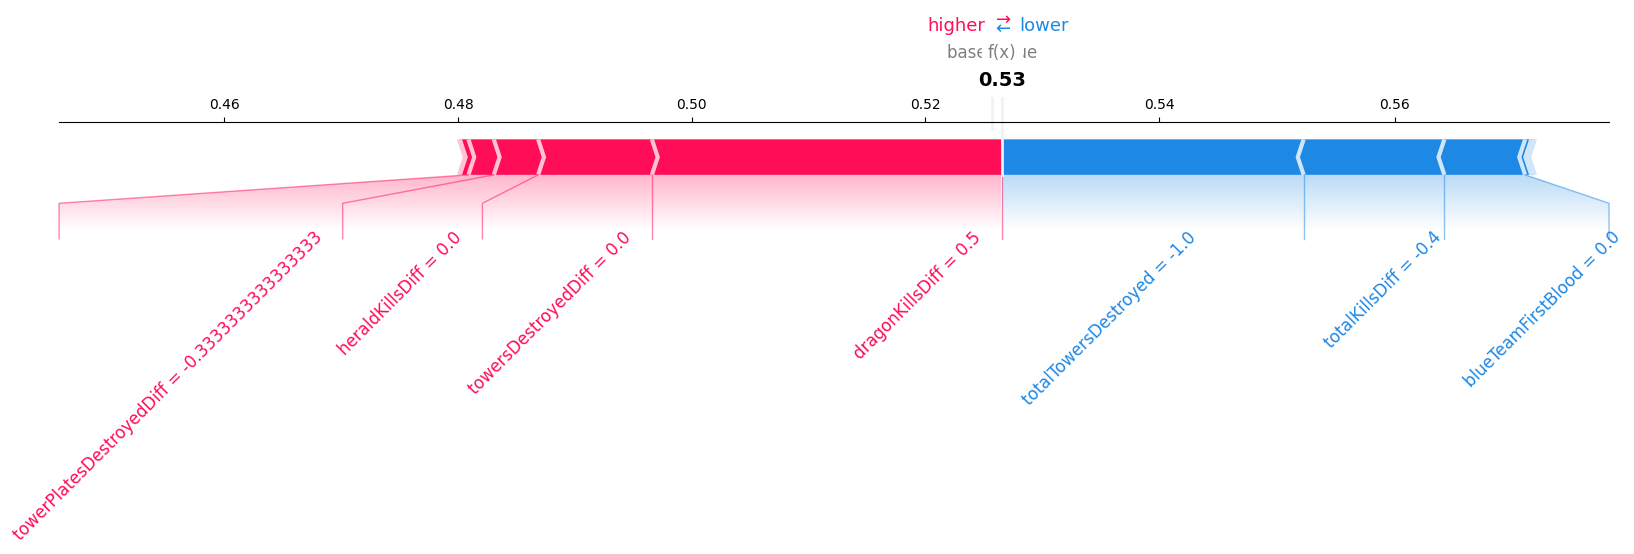

In [26]:

import shap

# 1. Extraer las piezas del Pipeline
# 2. Preparar los datos CORRECTOS (Escalados) para el Explainer
# Tomamos la muestra cruda y la escalamos
sample_data_raw = shap.sample(X_val, 50, random_state=0)
sample_data_scaled = scaler.transform(sample_data_raw)

# Tomamos la instancia cruda y la escalamos
instance_raw = X_val.iloc[[0]]  # DataFrame (crudo)
instance_scaled = scaler.transform(instance_raw)  # Numpy Array (escalado)

# 3. Crear el Explainer con datos ESCALADOS
# Ahora el modelo recibe lo que espera (números pequeños)
explainer = shap.LinearExplainer(best_dt, sample_data_scaled)

# 4. Calcular SHAP values sobre la instancia ESCALADA
shap_values = explainer.shap_values(instance_scaled)

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    instance_raw.iloc[0],
    matplotlib=True,
    text_rotation=45,
    link="logit"
)

In [27]:
shap_values_summary = explainer.shap_values(sample_data_scaled)

/tmp/ipykernel_14453/2325263966.py:2: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



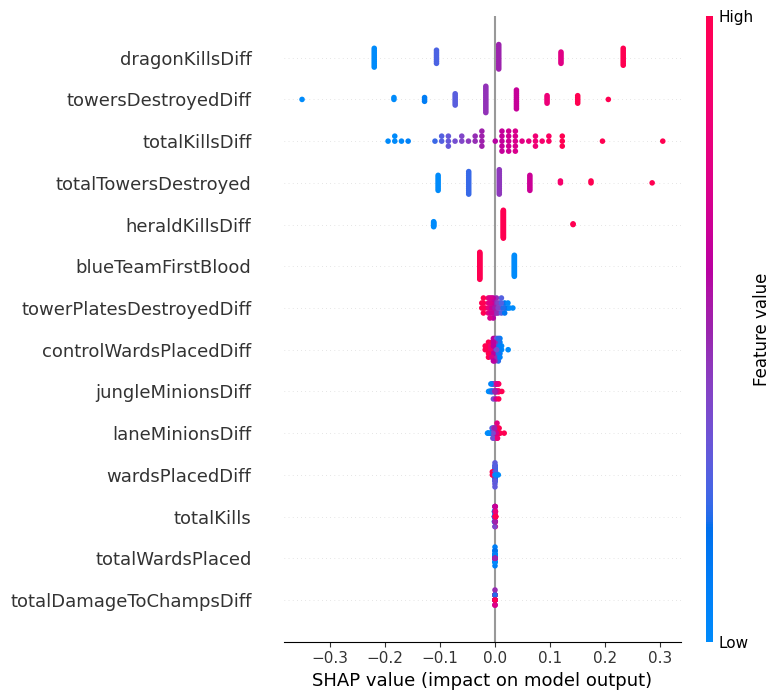

In [28]:
plt.figure(dpi=100)
shap.summary_plot(
    shap_values_summary,
    sample_data_raw,
    plot_type="dot",
    show=False
)